In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf
# https://arxiv.org/abs/1705.04058
# https://www.tensorflow.org/tutorials/generative/style_transfer#run_gradient_descent
# https://medium.com/data-science-group-iitr/artistic-style-transfer-with-convolutional-neural-network-7ce2476039fd
# https://genekogan.com/works/style-transfer/
# https://shafeentejani.github.io/2016-12-27/style-transfer/

In [ ]:
import os
import numpy as np
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
import PIL.Image
import functools
import cv2
from skimage.transform import rotate
import time

In [ ]:
def salt_and_pepper(IMG):
    img = IMG#.copy()
    n_rows, n_cols = img.shape
    for row in range(n_rows):
        for col in range(n_cols):
            thresh = np.random.rand()
            if thresh > 0.5:
                img[row, col] = 1
            else:
                img[row, col] = 0
    return img

# Load content and style images

In [ ]:
# Load an image and limit its maximum dimension to 512 pixels.
# NOT PART OF THE MODEL
def load_img(path_to_img, max_dim=512):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
# Display image
# NOT PART OF THE MODEL
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  plt.axis('off')
  if title:
    plt.title(title)

In [ ]:

# Load images and display them
content_image = load_img('/content/drive/MyDrive/Tesis/Base/C1.jpg')
style_image = load_img('/content/drive/MyDrive/Tesis/Base/E1.jpg')
'''
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')
plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')
'''

"\nplt.figure(figsize=(12, 12))\nplt.subplot(1, 2, 1)\nimshow(content_image, 'Content Image')\nplt.subplot(1, 2, 2)\nimshow(style_image, 'Style Image')\n"

# Load pretrained model and use it for building ours

In [ ]:
# Load pretrained VGG19 and test its performance
# NOT PART OF THE MODEL
x = tf.keras.applications.vgg19.preprocess_input(255 * content_image)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape # predicted a vector of 1000 classes (probabilities)

574726144/574710816 [==============================] - 7s 0us/step


TensorShape([1, 1000])

In [ ]:
# Decode only the top5 most probable classes
# NOT PART OF THE MODEL
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]
# Labrador is the most probable class

49152/35363 [=========================================] - 0s 0us/step


[('prison', 0.09200443),
 ('punching_bag', 0.070238456),
 ('sweatshirt', 0.04143095),
 ('sunglasses', 0.030156419),
 ('window_shade', 0.026103571)]

In [ ]:
# Load model again, this time without classification layers
# NOT PART OF THE MODEL, but required to know the layer's names
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
for layer in vgg.layers:
  print(layer.name)

80150528/80134624 [==============================] - 2s 0us/step
input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
# Select hidden layers for the style and content of the image
content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

In [ ]:
# Create a vgg-like model with a list of intermediate output values
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
# Create one model and plot it
# NOT PART OF THE MODEL
style_extractor = vgg_layers(style_layers)
style_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
# Apply model on the style image and see statistics of each layer's output
# NOT PART OF THE MODEL
style_outputs = style_extractor(255 * style_image)

for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 418, 512, 64)
  min:  0.0
  max:  764.4889
  mean:  38.475937

block2_conv1
  shape:  (1, 209, 256, 128)
  min:  0.0
  max:  4052.842
  mean:  205.48619

block3_conv1
  shape:  (1, 104, 128, 256)
  min:  0.0
  max:  10787.286
  mean:  203.15785

block4_conv1
  shape:  (1, 52, 64, 512)
  min:  0.0
  max:  18011.168
  mean:  666.97156

block5_conv1
  shape:  (1, 26, 32, 512)
  min:  0.0
  max:  3034.6772
  mean:  35.369156



# Compute style and content

In [ ]:
# Normalized Gram Matrix to measure correlations across the different feature maps
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
  return result / (num_locations)

In [ ]:
# Model to return style and content tensors
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = 255.0 * inputs
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [ ]:
# Test it on the content image
# NOT PART OF THE MODEL
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.005609058
    max:  29260.578
    mean:  357.68448

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  102603.4
    mean:  12838.291

   block3_conv1
    shape:  (1, 256, 256)
    min:  1.3319353
    max:  239632.88
    mean:  11638.896

   block4_conv1
    shape:  (1, 512, 512)
    min:  5.8926563
    max:  2553921.5
    mean:  179395.69

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  108781.445
    mean:  1364.3728

Contents:
   block5_conv2
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  763.20276
    mean:  14.285291


# Optimize: gradient descent

In [ ]:
# Make sure image is between 0 and 1
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
# Define an optimizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
# Combined loss function
def style_content_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) 
                        for name in style_outputs.keys()])
  style_loss *= style_weight / len(style_layers)
  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2) 
                          for name in content_outputs.keys()])
  content_loss *= content_weight / len(content_layers)
  loss = style_loss + content_loss
  return loss

In [ ]:
# Change tensor to image, so we can display it
# NOT PART OF THE MODEL, but required for displaying
def tensor_to_image(tensor):
  tensor = 255 * tensor
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

# Experimento

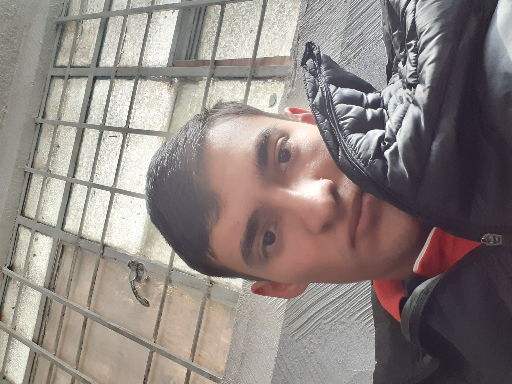

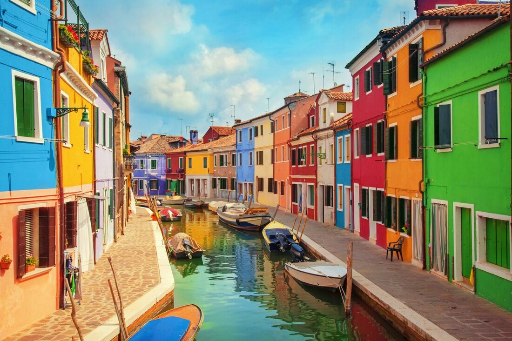

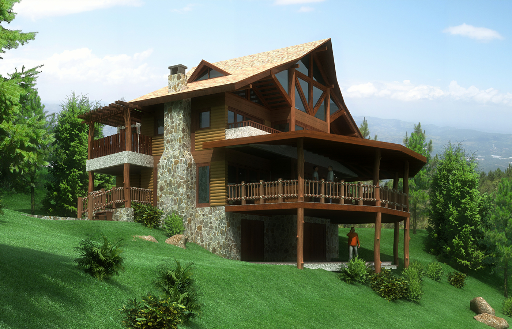

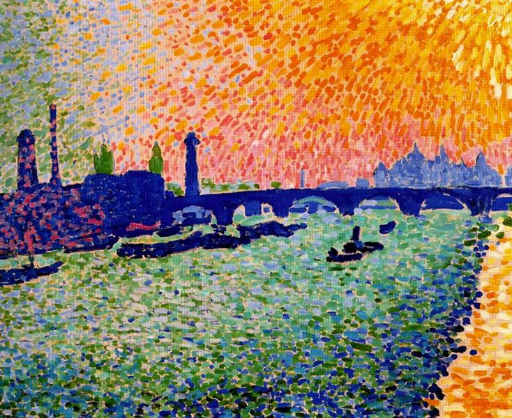

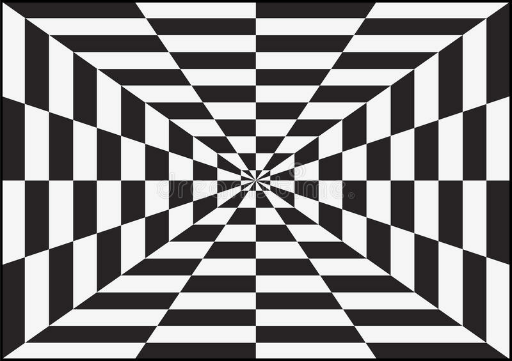

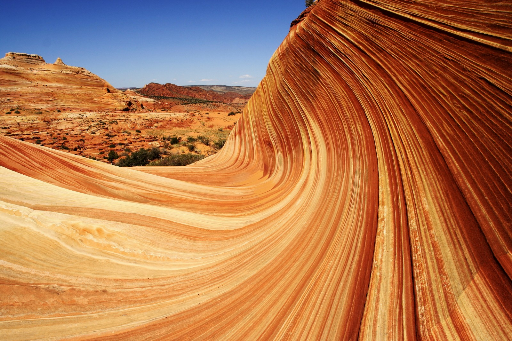

"\nC1 = load_img('/content/drive/MyDrive/Tesis/Base/C1.jpg')\n#C1 = rotate(C1, 90)\ndisplay.display(tensor_to_image(content_image))\nC2 = load_img('/content/drive/MyDrive/Tesis/Base/C2.jpg')\ndisplay.display(tensor_to_image(content_image))\nC3 = load_img('/content/drive/MyDrive/Tesis/Base/C3.jpg')\ndisplay.display(tensor_to_image(content_image))\nE1 = load_img('/content/drive/MyDrive/Tesis/Base/E1.jpg')\ndisplay.display(tensor_to_image(content_image))\nE2 = load_img('/content/drive/MyDrive/Tesis/Base/E2.jpg')\ndisplay.display(tensor_to_image(content_image))\nE3 = load_img('/content/drive/MyDrive/Tesis/Base/E3.jpg')\ndisplay.display(tensor_to_image(content_image))   \n\ncont = [(C1, 'C1'),\n        (C2, 'C2'),\n        (C3, 'C3')]\nest = [(E1, 'E1'),\n        (E2, 'E2'),\n        (E3, 'E3')]\n"

In [ ]:
# Load images and display them
cont = ['/content/drive/MyDrive/Tesis/Base/C1.jpg', 
        '/content/drive/MyDrive/Tesis/Base/C2.jpg', 
        '/content/drive/MyDrive/Tesis/Base/C3.jpg']
est = ['/content/drive/MyDrive/Tesis/Base/E1.jpg', 
       '/content/drive/MyDrive/Tesis/Base/E2.jpg', 
       '/content/drive/MyDrive/Tesis/Base/E3.jpg']

for c in cont:
  content_image = load_img(c)
  display.display(tensor_to_image(content_image))
for e in est:     
  style_image = load_img(e)
  display.display(tensor_to_image(style_image))   

'''
C1 = load_img('/content/drive/MyDrive/Tesis/Base/C1.jpg')
#C1 = rotate(C1, 90)
display.display(tensor_to_image(content_image))
C2 = load_img('/content/drive/MyDrive/Tesis/Base/C2.jpg')
display.display(tensor_to_image(content_image))
C3 = load_img('/content/drive/MyDrive/Tesis/Base/C3.jpg')
display.display(tensor_to_image(content_image))
E1 = load_img('/content/drive/MyDrive/Tesis/Base/E1.jpg')
display.display(tensor_to_image(content_image))
E2 = load_img('/content/drive/MyDrive/Tesis/Base/E2.jpg')
display.display(tensor_to_image(content_image))
E3 = load_img('/content/drive/MyDrive/Tesis/Base/E3.jpg')
display.display(tensor_to_image(content_image))   

cont = [(C1, 'C1'),
        (C2, 'C2'),
        (C3, 'C3')]
est = [(E1, 'E1'),
        (E2, 'E2'),
        (E3, 'E3')]
'''

In [ ]:
# Weight for each loss
content_weight = 10 ** (-10) # alfa de la presentación
style_weight = 10 ** (10) # beta de la presentación
ab = content_weight/style_weight
ab = format(ab,'f')
print(ab)

0.000000


In [ ]:
# Set style and content target values
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [ ]:
# Define a training step function with forward and backward passes
total_variation_weight = 30 # Hyperparameter

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    print(loss)
    loss += total_variation_weight * tf.image.total_variation(image) # pixel gradients*

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))
#* Penalize changes, makes image smooth

In [ ]:
'''
for c in cont:
  content_image = load_img(c)
  for e in est:     
    style_image = load_img(e)   
     # Define a training step function with forward and backward passes
    total_variation_weight = 30 # Hyperparameter

    @tf.function()
    def train_step(image):
      with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        print(loss)
        loss += total_variation_weight * tf.image.total_variation(image) # pixel gradients*

      grad = tape.gradient(loss, image)
      opt.apply_gradients([(grad, image)])
      image.assign(clip_0_1(image))
    #* Penalize changes, makes image smooth

    # Set style and content target values
    style_targets = extractor(style_image)['style']
    content_targets = extractor(content_image)['content']
    # Variable for the image to be optimized
    image = tf.Variable(content_image) # Imagen x aleatoria inicial
    # Train it for epochs
    import time
    start = time.time()

    epochs = 10
    steps_per_epoch = 50

    step = 0
    for n in range(epochs):
      for m in range(steps_per_epoch):
        step += 1
        train_step(image)
      #display.display(tensor_to_image(image))
      #print("Época: {}; Alfa: {}; Beta: {}".format(n + 1, content_weight, style_weight))
    # Guarda la imagen final con distintos nombres
    st = '/content/drive/MyDrive/Tesis/Resultados10-20/' + c[-6:-4] + e[-6:-4] + '.png'
    tensor_to_image(image).save(st)
    end = time.time()
    print("Total time: {:.1f}".format(end-start))
'''

'\nfor c in cont:\n  content_image = load_img(c)\n  for e in est:     \n    style_image = load_img(e)   \n     # Define a training step function with forward and backward passes\n    total_variation_weight = 30 # Hyperparameter\n\n    @tf.function()\n    def train_step(image):\n      with tf.GradientTape() as tape:\n        outputs = extractor(image)\n        loss = style_content_loss(outputs)\n        print(loss)\n        loss += total_variation_weight * tf.image.total_variation(image) # pixel gradients*\n\n      grad = tape.gradient(loss, image)\n      opt.apply_gradients([(grad, image)])\n      image.assign(clip_0_1(image))\n    #* Penalize changes, makes image smooth\n\n    # Set style and content target values\n    style_targets = extractor(style_image)[\'style\']\n    content_targets = extractor(content_image)[\'content\']\n    # Variable for the image to be optimized\n    image = tf.Variable(content_image) # Imagen x aleatoria inicial\n    # Train it for epochs\n    import time\

Tensor("add:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)
Época: 10; Alfa: 1; Beta: 1e-05


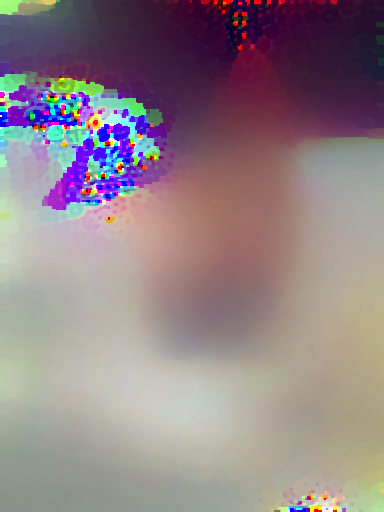

Total time: 95.3
Tensor("add:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)
Época: 10; Alfa: 10; Beta: 1e-05


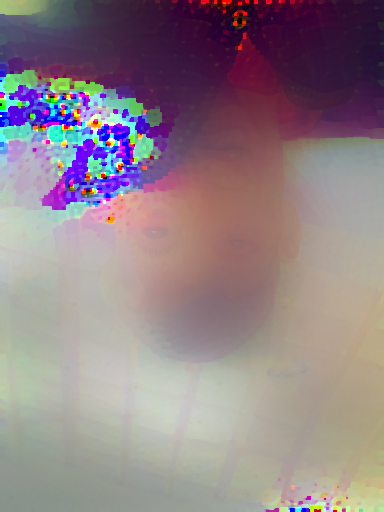

Total time: 95.4
Tensor("add:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)
Época: 10; Alfa: 100; Beta: 1e-05


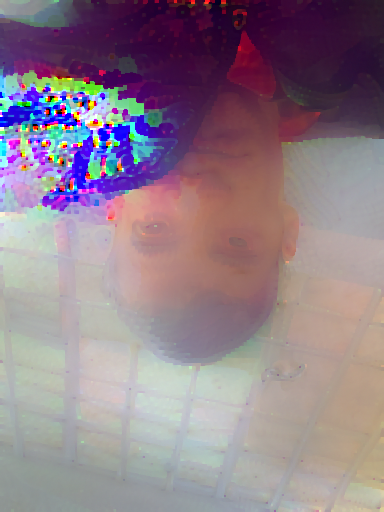

Total time: 95.8
Tensor("add:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)
Época: 10; Alfa: 1; Beta: 0.0001


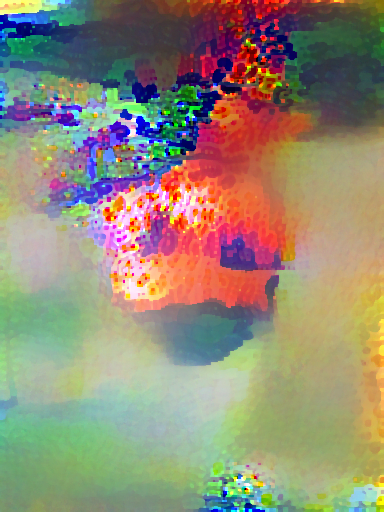

Total time: 96.2
Tensor("add:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)
Época: 10; Alfa: 10; Beta: 0.0001


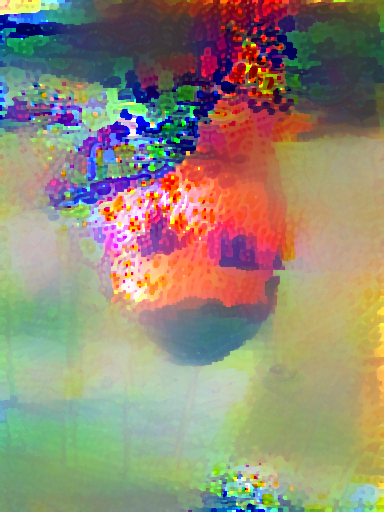

Total time: 96.2
Tensor("add:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)
Época: 10; Alfa: 100; Beta: 0.0001


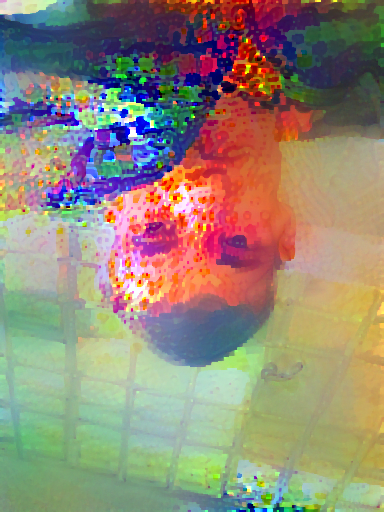

Total time: 96.2
Tensor("add:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)
Época: 10; Alfa: 1; Beta: 0.0005


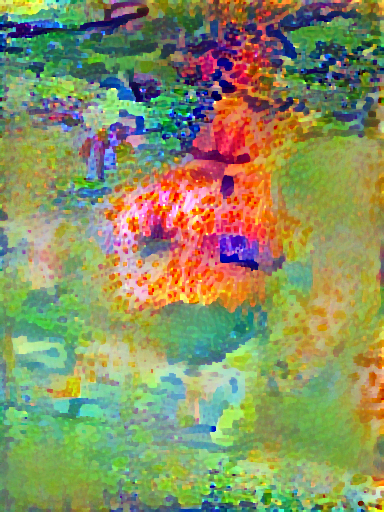

Total time: 96.1
Tensor("add:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)
Época: 10; Alfa: 10; Beta: 0.0005


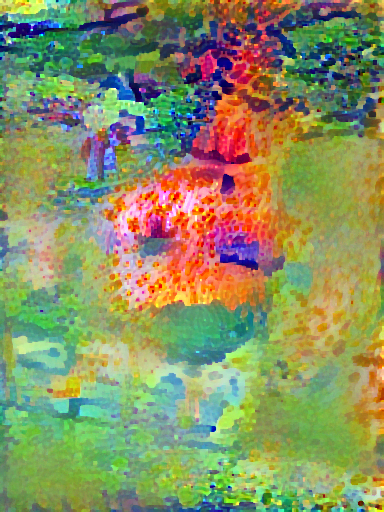

Total time: 96.1
Tensor("add:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)
Época: 10; Alfa: 100; Beta: 0.0005


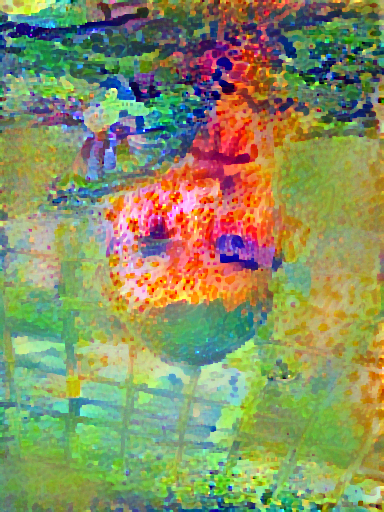

Total time: 96.1
Tensor("add:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)
Época: 10; Alfa: 1; Beta: 0.001


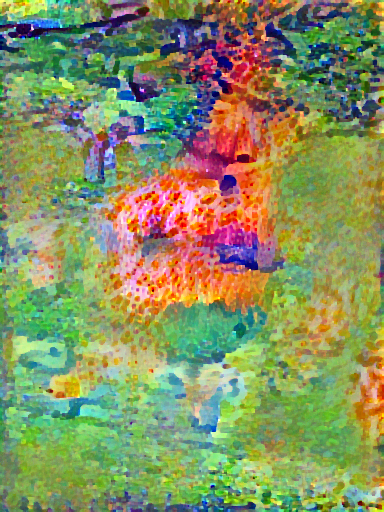

Total time: 96.1
Tensor("add:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)
Época: 10; Alfa: 10; Beta: 0.001


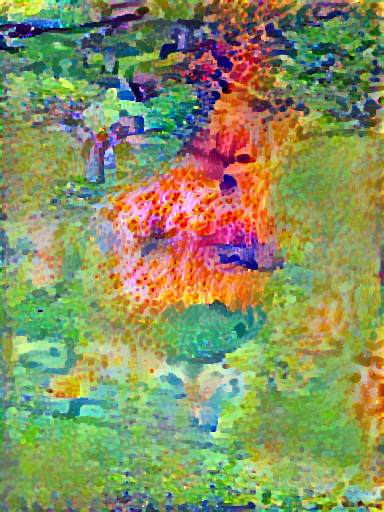

Total time: 96.2
Tensor("add:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)
Época: 10; Alfa: 100; Beta: 0.001


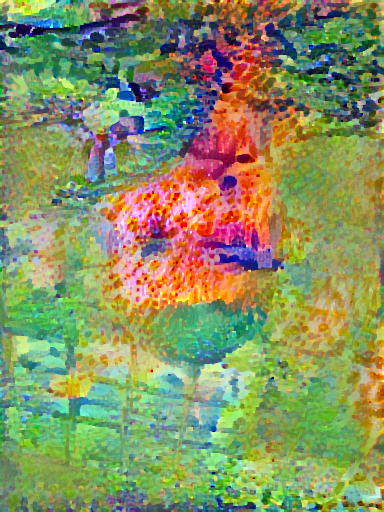

Total time: 96.1
Tensor("add:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)
Época: 10; Alfa: 1; Beta: 0.01


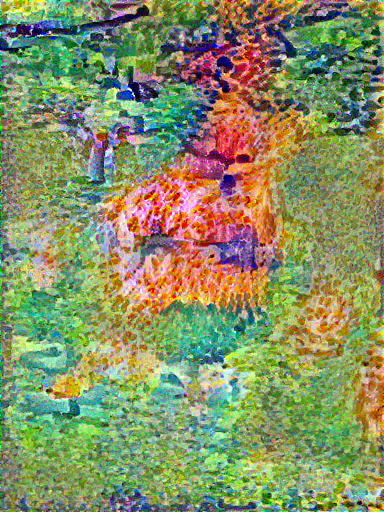

Total time: 96.1
Tensor("add:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)
Época: 10; Alfa: 10; Beta: 0.01


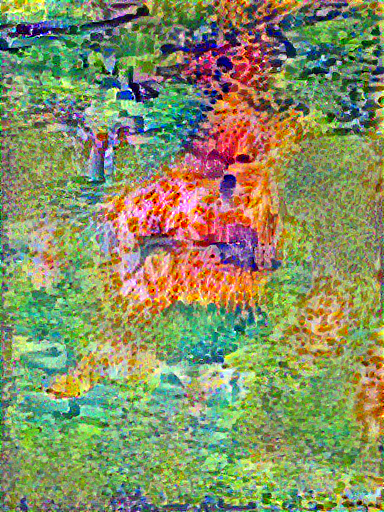

Total time: 96.2
Tensor("add:0", shape=(), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)
Época: 10; Alfa: 100; Beta: 0.01


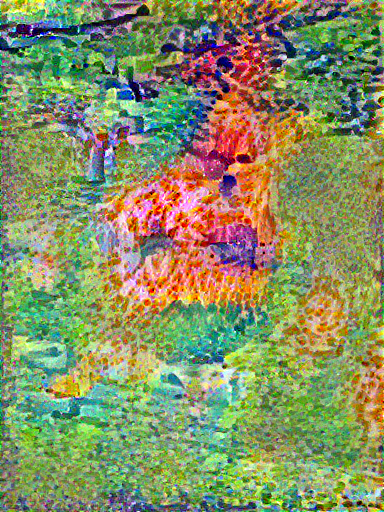

Total time: 96.1


In [ ]:
alfa = [1, 10,100]
beta = [0.00001, 0.0001, 0.0005, 0.001, 0.01]
for i in beta:
  for j in alfa:
    # Weight for each loss
    content_weight = j#10 ** (i - 5) # alfa
    style_weight = i#10 ** (j - 5) # beta
    #ab = content_weight/style_weight
    #ab = format(ab,'f')

    content_image = load_img('/content/drive/MyDrive/Tesis/Otros/i2.jpg')
    style_image = load_img('/content/drive/MyDrive/Tesis/Base/E1.jpg') 
    inicial = content_image#load_img('/content/drive/MyDrive/Tesis/Otros/rui.jpg')
    total_variation_weight = 30
    @tf.function()
    def train_step(image):
      with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        print(loss)
        loss += total_variation_weight * tf.image.total_variation(image) # pixel gradients*

      grad = tape.gradient(loss, image)
      opt.apply_gradients([(grad, image)])
      image.assign(clip_0_1(image))
    #* Penalize changes, makes image smooth

    # Set style and content target values
    style_targets = extractor(style_image)['style']
    content_targets = extractor(content_image)['content']
    # Variable for the image to be optimized
    image = tf.Variable(inicial) # Imagen x aleatoria inicial
    # Train it for epochs
    start = time.time()

    epochs = 10
    steps_per_epoch = 42

    step = 0
    for n in range(epochs):
      for m in range(steps_per_epoch):
        step += 1
        train_step(image)  
    # Guarda la imagen final con distintos nombres
    st = '/content/drive/MyDrive/Tesis/Final/alfa==' + str(j) +  'beta==' + str(i) + '.png' #'alfa10ala' + str(i - 5) + 'beta10ala' + str(j - 5) + '.png'
    tensor_to_image(image).save(st)
    print("Época: {}; Alfa: {}; Beta: {}".format(n + 1, content_weight, style_weight))
    #print(ab)
    display.display(tensor_to_image(image))
    end = time.time()
    print("Total time: {:.1f}".format(end-start))